In [1]:
!nvidia-smi

Sat Jul 30 08:11:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install nltk
!pip install gensim
!pip install sklearn
!pip install pyLDAvis

In [7]:
import csv
import pandas as pd
import re
import numpy as np
import string
#from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [8]:
# Load dataset
df = pd.read_csv("/Users/jiyoung/Master thesis/data_cleaned/data_clustering.csv")

In [9]:
#df = pd.read_csv("/content/clustering-thesis-jiji/data_clustering.csv", sep=',', encoding='utf-8') 
df.head()

,uuid,name,category_groups_list
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,"Content and Publishing,Internet Services,Media..."
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,"Internet Services,Media and Entertainment"
2,60485007-8856-bbac-aa1b-c535c41f5f47,Omnidrive,"Commerce and Shopping,Internet Services,Media ..."
3,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni,"Community and Lifestyle,Other"
4,3d16cb4c-911e-75c0-de5a-15c316b39f98,StumbleUpon,"Commerce and Shopping,Internet Services,Media ..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157514 entries, 0 to 157513
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   uuid                  157514 non-null  object
 1   name                  157514 non-null  object
 2   category_groups_list  157514 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [11]:
type(df['category_groups_list'][0])

str

In [ ]:
# Convert Data frame's column to list 
# data = df.category_groups_list.values.tolist()  
# data

In [12]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiyoung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jiyoung/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
# Remove Stop Words
stop = set(stopwords.words('english'))
# Exclude any punctuations like comma, dot, etc...and replace it with 'space'
exclude = set(string.punctuation)
# Do lemmatization
lemma = WordNetLemmatizer()
def clean(category_groups_list):
    stop_free = " ".join([i for i in category_groups_list.lower().split() if i not in stop])
    clean_words = ''.join(' ' if c in string.punctuation else c for c in stop_free)
    punc_free = ''.join(ch for ch in clean_words if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [15]:
df['category_cleaned'] = df['category_groups_list'].apply(clean).str.lower()

In [16]:
df.head()

,uuid,name,category_groups_list,category_cleaned
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,"Content and Publishing,Internet Services,Media...",content publishing internet service medium ent...
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,"Internet Services,Media and Entertainment",internet service medium entertainment
2,60485007-8856-bbac-aa1b-c535c41f5f47,Omnidrive,"Commerce and Shopping,Internet Services,Media ...",commerce shopping internet service medium ente...
3,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni,"Community and Lifestyle,Other",community lifestyle other
4,3d16cb4c-911e-75c0-de5a-15c316b39f98,StumbleUpon,"Commerce and Shopping,Internet Services,Media ...",commerce shopping internet service medium ente...


In [17]:
category_final = [x.split(' ') for x in df['category_cleaned']]

In [ ]:
category_final

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(category_final)
# Create Corpus
# Term Document Frequency (corpus)
corpus = [id2word.doc2bow(text) for text in category_final]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [20]:
# check what word corresponds to a given id (in readable format)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('content', 1),
  ('entertainment', 1),
  ('internet', 1),
  ('marketing', 1),
  ('medium', 1),
  ('publishing', 1),
  ('sale', 1),
  ('service', 1)]]

In [21]:
id2word[2]

'internet'

In [22]:
# TFIDF vectorization on the text column:# Term Frequency Inverse Document Frequency 
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
print(corpus_tfidf[0])

[(0, 0.49037894131751), (1, 0.3026890722568967), (2, 0.24078192221557027), (3, 0.3573646787024616), (4, 0.3026890722568967), (5, 0.49037894131751), (6, 0.3573646787024616), (7, 0.14973535876038904)]


In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.370*"service" + 0.164*"financial" + 0.100*"internet" + 0.077*"software" + '
  '0.071*"professional" + 0.063*"other" + 0.050*"payment" + '
  '0.032*"administrative" + 0.032*"lending" + 0.032*"investment"'),
 (1,
  '0.207*"health" + 0.207*"care" + 0.088*"science" + 0.088*"engineering" + '
  '0.081*"manufacturing" + 0.072*"biotechnology" + 0.052*"sustainability" + '
  '0.051*"community" + 0.051*"lifestyle" + 0.040*"energy"'),
 (2,
  '0.264*"information" + 0.264*"technology" + 0.128*"software" + '
  '0.111*"hardware" + 0.056*"consumer" + 0.055*"electronics" + 0.034*"privacy" '
  '+ 0.034*"security" + 0.021*"other" + 0.010*"military"'),
 (3,
  '0.154*"data" + 0.154*"analytics" + 0.121*"science" + 0.121*"engineering" + '
  '0.111*"software" + 0.098*"intelligence" + 0.098*"artificial" + '
  '0.036*"agriculture" + 0.036*"farming" + 0.030*"hardware"'),
 (4,
  '0.167*"shopping" + 0.167*"commerce" + 0.118*"food" + 0.118*"beverage" + '
  '0.078*"marketing" + 0.078*"sale" + 0.055*"good" +

In [ ]:
print(doc_lda[0])

([(0, 0.016034018), (1, 0.015873015), (2, 0.015873015), (3, 0.015873015), (4, 0.23809507), (5, 0.6823788), (6, 0.015873015)], [(0, [5]), (1, [5]), (2, [5]), (3, [4]), (4, [5]), (5, [5]), (6, [4]), (7, [5])], [(0, [(5, 1.0)]), (1, [(5, 1.0)]), (2, [(5, 0.999771)]), (3, [(4, 0.9999993)]), (4, [(5, 1.0)]), (5, [(5, 1.0)]), (6, [(4, 0.9999993)]), (7, [(5, 0.9989937)])])


In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=category_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3425993549874337


retry

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, alpha=.1, eta=0.1,random_state=0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())  

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=category_final, start=5, limit=21, step=1)

In [19]:
# retry 2 times

# supporting function
def tuning_compute_coherence_values(dictionary, corpus, k, a, b):

        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=a, eta=b, random_state=0)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=category_final, dictionary=id2word, coherence='c_v')
        
        return coherence_model_lda.get_coherence()

In [41]:
num_of_docs = len(corpus)
corpus_sets_75 = gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))

corpus_sets_100 = [corpus]

# gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.25)), 
# gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 

In [47]:
hold_out_test_sets = gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.25))

In [ ]:
# Main Hyperparameters_search
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 20
step_size = 3
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = tuning_compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [70]:
# supporting function2 
def tuning_compute_perplexity_values(dictionary, corpus, k):

        lda_model_v2 = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=0.31, eta=0.31, random_state=0)
        perplexity_model_lda = lda_model_v2.log_perplexity(corpus)        
        return perplexity_model_lda 


In [63]:
corpus_sets = gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))

In [ ]:
lda_model_v2 = gensim.models.LdaMulticore(corpus=corpus_sets, id2word=id2word, num_topics=17, alpha=0.31, eta=0.31, random_state=0)
perplexity_model_lda = lda_model_v2.log_perplexity(corpus_sets) 

In [85]:
perplexity_model_lda

-3.7846114793797923

In [ ]:
# num_topics = 5, Perplexity:  -3.7287984148958913
# num_topics = 8, Perplexity:  -3.7094448147849612
# num_topics = 11, Perplexity:  -3.76653605730551
# num_topics = 14, Perplexity:  -3.764863857178308
# num_topics = 17, Perplexity:  -3.7846114793797923

In [5]:
results_v2 = pd.read_csv('/content/lda_tuning_results.csv')

In [8]:
best = results_v2[results_v2.Coherence == results_v2.Coherence.max()]

print('The highest coherence score is {}'.format(best.Coherence. values[0]))

The highest coherence score is 0.364267521725306


In [9]:
print('And the corresponding parameters are following:') 
best[['Topics', 'Alpha', 'Beta']].reset_index(drop=True)

And the corresponding parameters are following:


,Topics,Alpha,Beta
0,14,0.31,0.31


In [87]:
# filter the results
results = pd.read_csv('/content/lda_tuning_results.csv')
results_for_vis = results[results['Alpha']=='0.31']
results_for_vis = results_for_vis[results_for_vis['Beta']=='0.31']
results_for_vis_75val = results_for_vis[results_for_vis['Validation_Set']=='75% Corpus']
results_for_vis_100val = results_for_vis[results_for_vis['Validation_Set']=='100% Corpus']

In [88]:
results_for_vis_75val

,Validation_Set,Topics,Alpha,Beta,Coherence
6,75% Corpus,5,0.31,0.31,0.339189
36,75% Corpus,8,0.31,0.31,0.341566
66,75% Corpus,11,0.31,0.31,0.338536
96,75% Corpus,14,0.31,0.31,0.364268
126,75% Corpus,17,0.31,0.31,0.349975


In [89]:
perplexity = [-3.7287984148958913, -3.7094448147849612, -3.76653605730551, -3.764863857178308, -3.7846114793797923]
# num_topics = 5, Perplexity:  -3.7287984148958913
# num_topics = 8, Perplexity:  -3.7094448147849612
# num_topics = 11, Perplexity:  -3.76653605730551
# num_topics = 14, Perplexity:  -3.764863857178308
# num_topics = 17, Perplexity:  -3.7846114793797923
results_for_vis_75val_v2 = pd.DataFrame(results_for_vis_75val)
results_for_vis_75val_v2['Perplexity'] = perplexity

In [90]:
results_for_vis_75val_v2

,Validation_Set,Topics,Alpha,Beta,Coherence,Perplexity
6,75% Corpus,5,0.31,0.31,0.339189,-3.728798
36,75% Corpus,8,0.31,0.31,0.341566,-3.709445
66,75% Corpus,11,0.31,0.31,0.338536,-3.766536
96,75% Corpus,14,0.31,0.31,0.364268,-3.764864
126,75% Corpus,17,0.31,0.31,0.349975,-3.784611


In [33]:
results_for_vis_100val

,Validation_Set,Topics,Alpha,Beta,Coherence
156,100% Corpus,5,0.31,0.31,0.339098
186,100% Corpus,8,0.31,0.31,0.336851
216,100% Corpus,11,0.31,0.31,0.337531
246,100% Corpus,14,0.31,0.31,0.356851
276,100% Corpus,17,0.31,0.31,0.346507


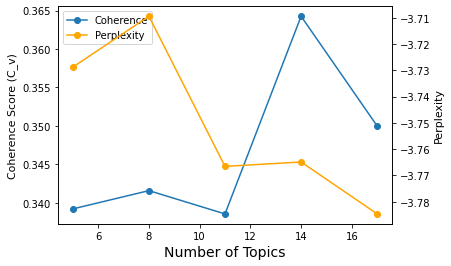

In [111]:
import pylab as pl
import matplotlib.pyplot as plt
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
coh_plot = ax.plot(results_for_vis_75val_v2.Topics, results_for_vis_75val_v2['Coherence'], marker='o', label='Coherence')
# set x-axis label
ax.set_xlabel('Number of Topics', fontsize = 14)
# set y-axis label
ax.set_ylabel('Coherence Score (C_v)',fontsize=11)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
perp_plot = ax2.plot(results_for_vis_75val_v2.Topics, results_for_vis_75val_v2['Perplexity'], color= 'orange', marker='o', label='Perplexity')
ax2.set_ylabel('Perplexity', fontsize=11)

plots = coh_plot+perp_plot
labs = [l.get_label() for l in plots]
ax.legend(plots, labs, loc='best')

plt.show()

# save the plot as a file
fig.savefig('coherence_perplexity_plot.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

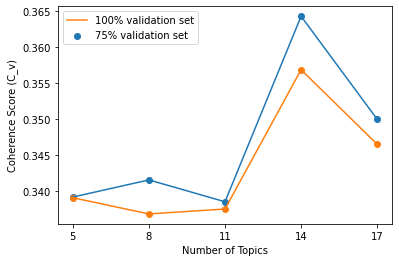

In [73]:
import pylab as pl
import matplotlib.pyplot as plt

plt.plot(np.array(results_for_vis_75val['Topics']), np.array(results_for_vis_75val['Coherence']))
plt.scatter(np.array(results_for_vis_75val['Topics']), np.array(results_for_vis_75val['Coherence']), label ='75% validation set')
plt.ylabel('Coherence Score (C_v)')
plt.xlabel('Number of Topics')
plt.xticks(np.array(results_for_vis_75val['Topics']))

plt.plot(np.array(results_for_vis_100val['Topics']), np.array(results_for_vis_100val['Coherence']), label ='100% validation set')
plt.scatter(np.array(results_for_vis_100val['Topics']), np.array(results_for_vis_100val['Coherence']))
plt.legend(loc='best')

plt.show()

#CHOOSE THIS PLOT (0.31, 0.31)

In [35]:
results_for_vis2 = results[results['Alpha']=='0.31']
results_for_vis2 = results_for_vis2[results_for_vis2['Beta']=='0.61']
results_for_vis2_75val = results_for_vis2[results_for_vis2['Validation_Set']=='75% Corpus']
results_for_vis2_100val = results_for_vis2[results_for_vis2['Validation_Set']=='100% Corpus']

In [36]:
results_for_vis2_75val

,Validation_Set,Topics,Alpha,Beta,Coherence
7,75% Corpus,5,0.31,0.61,0.339607
37,75% Corpus,8,0.31,0.61,0.341566
67,75% Corpus,11,0.31,0.61,0.338536
97,75% Corpus,14,0.31,0.61,0.363242
127,75% Corpus,17,0.31,0.61,0.345841


In [37]:
results_for_vis2_100val

,Validation_Set,Topics,Alpha,Beta,Coherence
157,100% Corpus,5,0.31,0.61,0.339098
187,100% Corpus,8,0.31,0.61,0.336851
217,100% Corpus,11,0.31,0.61,0.337531
247,100% Corpus,14,0.31,0.61,0.356851
277,100% Corpus,17,0.31,0.61,0.345368


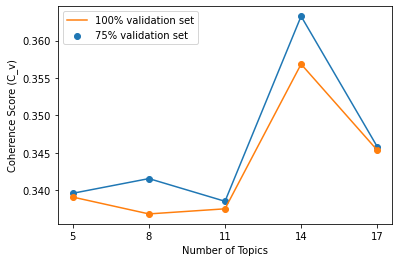

In [72]:
# now the plot
# import matplotlib.pyplot as plt
# plt.plot(np.array(results_for_vis2_100val['Topics']), np.array(results_for_vis2_100val['Coherence']))
# plt.scatter(np.array(results_for_vis2_100val['Topics']), np.array(results_for_vis2_100val['Coherence']))
# plt.ylabel('Coherence Score (C_v)')
# plt.xlabel('Number of Topics')
# plt.xticks(np.array(results_for_vis2_100val['Topics']))
# plt.show()


import pylab as pl
import matplotlib.pyplot as plt

plt.plot(np.array(results_for_vis2_75val['Topics']), np.array(results_for_vis2_75val['Coherence']))
plt.scatter(np.array(results_for_vis2_75val['Topics']), np.array(results_for_vis2_75val['Coherence']), label ='75% validation set')
plt.ylabel('Coherence Score (C_v)')
plt.xlabel('Number of Topics')
plt.xticks(np.array(results_for_vis2_75val['Topics']))

plt.plot(np.array(results_for_vis2_100val['Topics']), np.array(results_for_vis2_100val['Coherence']), label ='100% validation set')
plt.scatter(np.array(results_for_vis2_100val['Topics']), np.array(results_for_vis2_100val['Coherence']))
plt.legend(loc='best')

plt.show()

In [49]:
# filter the results
results_for_vis3 = results[results['Alpha']=='0.01']
results_for_vis3 = results_for_vis3[results_for_vis3['Beta']=='0.01']
results_for_vis3_75val = results_for_vis3[results_for_vis3['Validation_Set']=='75% Corpus']
results_for_vis3_100val = results_for_vis3[results_for_vis3['Validation_Set']=='100% Corpus']

In [50]:
results_for_vis3_75val

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,5,0.01,0.01,0.278750
30,75% Corpus,8,0.01,0.01,0.307398
60,75% Corpus,11,0.01,0.01,0.331364
90,75% Corpus,14,0.01,0.01,0.358968
120,75% Corpus,17,0.01,0.01,0.321452


In [51]:
results_for_vis3_100val

,Validation_Set,Topics,Alpha,Beta,Coherence
150,100% Corpus,5,0.01,0.01,0.332361
180,100% Corpus,8,0.01,0.01,0.294851
210,100% Corpus,11,0.01,0.01,0.336229
240,100% Corpus,14,0.01,0.01,0.355815
270,100% Corpus,17,0.01,0.01,0.324422


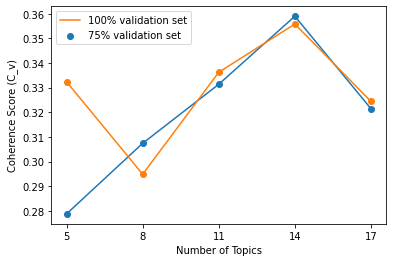

In [69]:
import pylab as pl
import matplotlib.pyplot as plt

plt.plot(np.array(results_for_vis3_75val['Topics']), np.array(results_for_vis3_75val['Coherence']))
plt.scatter(np.array(results_for_vis3_75val['Topics']), np.array(results_for_vis3_75val['Coherence']), label ='75% validation set')
plt.ylabel('Coherence Score (C_v)')
plt.xlabel('Number of Topics')
plt.xticks(np.array(results_for_vis3_75val['Topics']))

plt.plot(np.array(results_for_vis3_100val['Topics']), np.array(results_for_vis3_100val['Coherence']), label ='100% validation set')
plt.scatter(np.array(results_for_vis3_100val['Topics']), np.array(results_for_vis3_100val['Coherence']))
plt.legend(loc='best')

plt.show()

In [57]:
# filter the results
results_for_vis4 = results[results['Alpha']=='0.01']
results_for_vis4 = results_for_vis4[results_for_vis4['Beta']=='0.31']
results_for_vis4_75val = results_for_vis4[results_for_vis4['Validation_Set']=='75% Corpus']
results_for_vis4_100val = results_for_vis4[results_for_vis4['Validation_Set']=='100% Corpus']

In [58]:
results_for_vis4_75val

,Validation_Set,Topics,Alpha,Beta,Coherence
1,75% Corpus,5,0.01,0.31,0.285110
31,75% Corpus,8,0.01,0.31,0.307864
61,75% Corpus,11,0.01,0.31,0.331364
91,75% Corpus,14,0.01,0.31,0.357144
121,75% Corpus,17,0.01,0.31,0.321452


In [60]:
results_for_vis4_100val

,Validation_Set,Topics,Alpha,Beta,Coherence
151,100% Corpus,5,0.01,0.31,0.278100
181,100% Corpus,8,0.01,0.31,0.294851
211,100% Corpus,11,0.01,0.31,0.336229
241,100% Corpus,14,0.01,0.31,0.355815
271,100% Corpus,17,0.01,0.31,0.323982


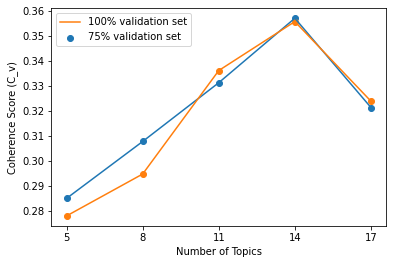

In [71]:
import pylab as pl
import matplotlib.pyplot as plt

plt.plot(np.array(results_for_vis4_75val['Topics']), np.array(results_for_vis4_75val['Coherence']))
plt.scatter(np.array(results_for_vis4_75val['Topics']), np.array(results_for_vis4_75val['Coherence']), label ='75% validation set')
plt.ylabel('Coherence Score (C_v)')
plt.xlabel('Number of Topics')
plt.xticks(np.array(results_for_vis4_75val['Topics']))

plt.plot(np.array(results_for_vis4_100val['Topics']), np.array(results_for_vis4_100val['Coherence']), label ='100% validation set')
plt.scatter(np.array(results_for_vis4_100val['Topics']), np.array(results_for_vis4_100val['Coherence']))
plt.legend(loc='best')

plt.show()

In [ ]:
# now the plot
import matplotlib.pyplot as plt
plt.plot(np.array(results_for_vis_75val['Topics']), np.array(results_for_vis_75val['Coherence']))
plt.scatter(np.array(results_for_vis_75val['Topics']), np.array(results_for_vis_75val['Coherence']))
plt.ylabel('Coherence Score (C_v)')
plt.xlabel('Number of Topics')
plt.xticks(np.array(results_for_vis_75val['Topics']))
plt.show()

# Final model based on hyperparameter tuning result

In [ ]:
lda_model_final_train = gensim.models.LdaMulticore(id2word=id2word, corpus=corpus_sets_75, num_topics=14, alpha=0.31, eta=0.31, random_state=0)

In [43]:
## Evaluate topic models
# Lower the perplexity better the model.
# Higher the topic coherence, the topic is more human interpretable.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_final_train = CoherenceModel(model=lda_model_final_train, texts=category_final, dictionary=id2word, coherence='c_v')
coherence_lda_final_train = coherence_model_lda_final_train.get_coherence()
print('\nCoherence Score: ', coherence_lda_final_train)


Coherence Score:  0.36436057647127557


In [ ]:
lda_model_final_val = gensim.models.LdaMulticore(id2word=id2word, corpus=hold_out_test_sets, num_topics=14, alpha=0.31, eta=0.31, random_state=0)

In [ ]:
# Compute Perplexity on 75% TRAIN DATASET
print('\nPerplexity: ', lda_model_final_train.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.
# Perplexity:  -3.7516944140215043

In [ ]:
# final model - Compute Perplexity on 25% VALIDATION DATASET
print('\nPerplexity: ', lda_model_final_val.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.
# Perplexity:  Perplexity:  -3.968317607967474

# From here - ORIGINALLY FULL FINAL MODEL (without train/test)
## train/val(test) was just needed for checkking model coherence and perplexity in previous code lines

In [23]:
lda_model_final = gensim.models.LdaMulticore(id2word=id2word, corpus=corpus, num_topics=14, alpha=0.31, eta=0.31, random_state=0)

In [24]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model_final.print_topics())
doc_lda_final = lda_model_final[corpus]

[(0,
  '0.265*"education" + 0.236*"software" + 0.159*"service" + 0.144*"internet" + '
  '0.050*"other" + 0.048*"hardware" + 0.028*"mobile" + 0.013*"apps" + '
  '0.007*"sport" + 0.005*"entertainment"'),
 (1,
  '0.167*"real" + 0.167*"estate" + 0.139*"sustainability" + 0.120*"energy" + '
  '0.078*"resource" + 0.078*"natural" + 0.074*"agriculture" + 0.074*"farming" '
  '+ 0.020*"other" + 0.019*"manufacturing"'),
 (2,
  '0.177*"audio" + 0.177*"music" + 0.174*"entertainment" + 0.173*"medium" + '
  '0.110*"software" + 0.041*"service" + 0.024*"internet" + 0.023*"video" + '
  '0.022*"other" + 0.014*"apps"'),
 (3,
  '0.211*"data" + 0.211*"analytics" + 0.129*"intelligence" + '
  '0.129*"artificial" + 0.128*"software" + 0.028*"science" + '
  '0.027*"engineering" + 0.020*"service" + 0.012*"information" + '
  '0.012*"technology"'),
 (4,
  '0.272*"entertainment" + 0.272*"medium" + 0.082*"publishing" + '
  '0.082*"content" + 0.073*"video" + 0.034*"event" + 0.026*"service" + '
  '0.025*"internet" + 0.0

In [19]:
print(doc_lda_final[0])

[(0, 0.02696079), (1, 0.025221752), (2, 0.02649471), (3, 0.025299495), (4, 0.37291378), (5, 0.026560508), (6, 0.24847095), (7, 0.025171366), (8, 0.025303578), (9, 0.09666397), (10, 0.0251606), (11, 0.025495175), (12, 0.025126059), (13, 0.025157264)]


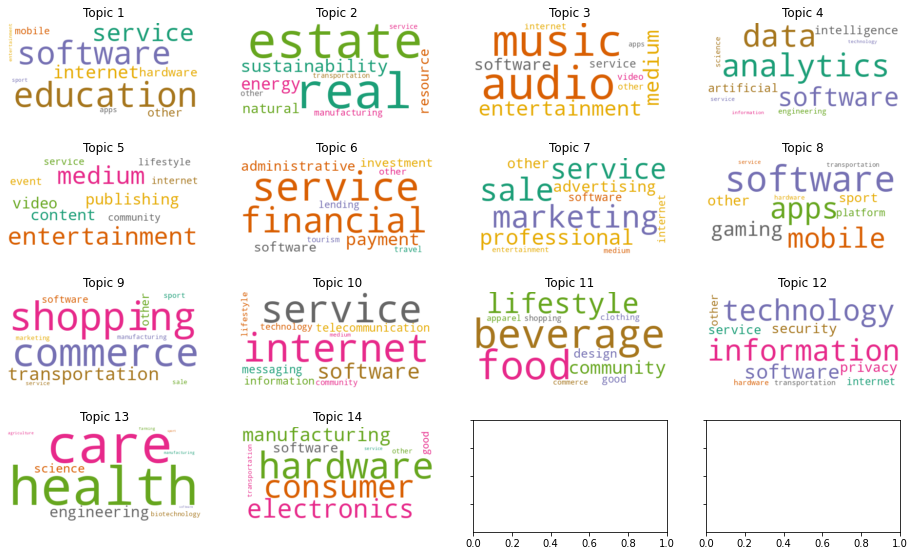

In [101]:
rows=4
cols=4

fig, ax = plt.subplots(rows, cols, sharex=False, sharey=True, figsize=(16,9.5))

row=0 
col=0 

for t in range(lda_model_final.num_topics):
    ax[row][col].imshow(WordCloud(background_color="white", colormap="Dark2").fit_words(dict(lda_model_final.show_topic(t, 10))), interpolation="bilinear")
    ax[row][col].set_title("Topic" + " " + str(t+1)) 
    ax[row][col].grid(False) 
    ax[row][col].axis("off")
    col=col+1
    if col==cols:
        col=0
        row=row+1

#plt.savefig(f"terms_all.png", bbox_inches='tight')

plt.show() 

In [20]:
## Evaluate topic models
# Lower the perplexity better the model.
# Higher the topic coherence, the topic is more human interpretable.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_final = CoherenceModel(model=lda_model_final, texts=category_final, dictionary=id2word, coherence='c_v')
coherence_lda_final = coherence_model_lda_final.get_coherence()
print('\nCoherence Score: ', coherence_lda_final)


Coherence Score:  0.35441909352611695


In [21]:
coherence_lda_final

0.35441909352611695

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_final.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.
# Perplexity:  -3.7216122923648762

In [23]:
def format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=category_final):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=category_final)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3611,"entertainment, medium, publishing, content, vi...","[content, publishing, internet, service, mediu..."
1,1,9.0,0.2797,"internet, service, software, telecommunication...","[internet, service, medium, entertainment]"
2,2,2.0,0.2522,"entertainment, medium, audio, music, software,...","[commerce, shopping, internet, service, medium..."
3,3,10.0,0.3980,"beverage, food, design, lifestyle, community, ...","[community, lifestyle, other]"
4,4,9.0,0.2246,"internet, service, software, telecommunication...","[commerce, shopping, internet, service, medium..."
5,5,13.0,0.2486,"hardware, consumer, electronics, manufacturing...","[hardware, software]"
6,6,4.0,0.4054,"entertainment, medium, publishing, content, vi...","[content, publishing, internet, service, mediu..."
7,7,2.0,0.4129,"entertainment, medium, audio, music, software,...","[internet, service, medium, entertainment, mob..."
8,8,2.0,0.4373,"entertainment, medium, audio, music, software,...","[internet, service, medium, entertainment, mus..."
9,9,8.0,0.2782,"commerce, shopping, transportation, other, sof...","[commerce, shopping, internet, service]"


In [24]:
pd.DataFrame(df_dominant_topic).to_csv('df_dominant_topic_final.csv', index=False)

**Topic Distribution across Documents**

In [25]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"entertainment, medium, publishing, content, vi...",4001.0,0.0254
1.0,9.0,"internet, service, software, telecommunication...",10814.0,0.0687
2.0,2.0,"entertainment, medium, audio, music, software,...",2493.0,0.0158
3.0,10.0,"beverage, food, design, lifestyle, community, ...",16453.0,0.1045
4.0,9.0,"internet, service, software, telecommunication...",10795.0,0.0685
...,...,...,...,...
157509.0,12.0,"care, health, engineering, science, biotechnol...",NaN,NaN
157510.0,0.0,"education, software, service, internet, hardwa...",NaN,NaN
157511.0,12.0,"care, health, engineering, science, biotechnol...",NaN,NaN
157512.0,7.0,"software, apps, mobile, gaming, other, sport, ...",NaN,NaN


In [26]:
pd.DataFrame(df_dominant_topics).to_csv('df_dominant_topic_distribution_first.csv', index=False)

**Find the most representative document for each topic**

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([sent_topics_sorteddf_lda, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5774,"education, software, service, internet, hardwa...","[education, hardware, internet, service, mobil..."
1,1.0,0.6630,"real, estate, sustainability, energy, resource...","[energy, manufacturing, natural, resource, oth..."
2,2.0,0.6273,"entertainment, medium, audio, music, software,...","[event, medium, entertainment, music, audio, o..."
3,3.0,0.6661,"data, analytics, software, intelligence, artif...","[artificial, intelligence, data, analytics, go..."
4,4.0,0.6940,"entertainment, medium, publishing, content, vi...","[community, lifestyle, content, publishing, ev..."


In [28]:
pd.DataFrame(sent_topics_sorteddf_lda).to_csv('sent_topics_sorteddf_lda_final.csv', index=False)

In [1]:
# Visualize the topics (optimal model - 14 topics) # FINAAL ONE but after WORDCLOUD CODE - slightly different from original final visualization somehow
vis_final = gensimvis.prepare(lda_model_final, corpus, id2word, sort_topics = False)
pyLDAvis.display(vis_final)

NameError: name 'gensimvis' is not defined

In [29]:
# Visualize the topics (optimal model - 14 topics) # FINAAL ONE
vis_final = gensimvis.prepare(lda_model_final, corpus, id2word, sort_topics = False)
pyLDAvis.display(vis_final)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


**Join back the newly created category one into previous dataset**

In [112]:
final_topics = pd.read_csv("/content/df_dominant_topic_final.csv", sep=',', encoding='utf-8') 
final_topics.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3611,"entertainment, medium, publishing, content, vi...","['content', 'publishing', 'internet', 'service..."
1,1,9.0,0.2797,"internet, service, software, telecommunication...","['internet', 'service', 'medium', 'entertainme..."
2,2,2.0,0.2522,"entertainment, medium, audio, music, software,...","['commerce', 'shopping', 'internet', 'service'..."
3,3,10.0,0.3980,"beverage, food, design, lifestyle, community, ...","['community', 'lifestyle', 'other']"
4,4,9.0,0.2246,"internet, service, software, telecommunication...","['commerce', 'shopping', 'internet', 'service'..."


In [113]:
# Default left join
df_new = df.join(final_topics)

In [114]:
df_new

,uuid,name,category_groups_list,category_cleaned,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,"Content and Publishing,Internet Services,Media...",content publishing internet service medium ent...,0,4.0,0.3611,"entertainment, medium, publishing, content, vi...","['content', 'publishing', 'internet', 'service..."
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,"Internet Services,Media and Entertainment",internet service medium entertainment,1,9.0,0.2797,"internet, service, software, telecommunication...","['internet', 'service', 'medium', 'entertainme..."
2,60485007-8856-bbac-aa1b-c535c41f5f47,Omnidrive,"Commerce and Shopping,Internet Services,Media ...",commerce shopping internet service medium ente...,2,2.0,0.2522,"entertainment, medium, audio, music, software,...","['commerce', 'shopping', 'internet', 'service'..."
3,4111dc8b-c0df-2d24-ed33-30cd137b3098,Geni,"Community and Lifestyle,Other",community lifestyle other,3,10.0,0.3980,"beverage, food, design, lifestyle, community, ...","['community', 'lifestyle', 'other']"
4,3d16cb4c-911e-75c0-de5a-15c316b39f98,StumbleUpon,"Commerce and Shopping,Internet Services,Media ...",commerce shopping internet service medium ente...,4,9.0,0.2246,"internet, service, software, telecommunication...","['commerce', 'shopping', 'internet', 'service'..."
...,...,...,...,...,...,...,...,...,...
157509,ca2995f5-6357-4f44-831d-21f8c3d8ad65,Gatherware,"Health Care,Software",health care software,157509,12.0,0.3219,"care, health, engineering, science, biotechnol...","['health', 'care', 'software']"
157510,be325b83-38db-45a0-8076-1fbbbc0c306e,Essential Personnel,"Education,Software",education software,157510,0.0,0.3482,"education, software, service, internet, hardwa...","['education', 'software']"
157511,c995724b-1379-4dad-85b7-c11caba7de38,Coyle Solar,"Energy,Hardware,Science and Engineering,Sustai...",energy hardware science engineering sustainabi...,157511,12.0,0.2491,"care, health, engineering, science, biotechnol...","['energy', 'hardware', 'science', 'engineering..."
157512,bf792d36-7e30-4fa7-b4b9-91daf337998f,CopyForward,Software,software,157512,7.0,0.2200,"software, apps, mobile, gaming, other, sport, ...",['software']


In [115]:
pd.DataFrame(df_new).to_csv('df_new_category_assigned.csv', index=False)